# Evaluation

The purpose of this notebook is to:

1. Calculate a baseline MSE
2. Compare model scores to the baseline MSE
3. Evaluate feature importance


## Import results

The imported train-test set is the preprocessed version of 2014-2018 (train) and 2019 (test) data. The sets are exported from `randomforest_ml.ipynb` and imported here to avoid having to re-split and preprocess the data again.

In [198]:
from joblib import load
import pandas as pd

target = "averageRating"
df = pd.read_csv("../data/preprocessed.csv")
X = df.drop(columns=[target])
y = df[target]

data = load('../results/elasticnet_results.joblib')
elasticnet_model = data['model']
elasticnet_pipe = data['pipe']
elasticnet_mses = data['test_mses']
elasticnet_params = data['params']

data = load('../results/randomforest_results.joblib')
randomforest_model = data['model']
randomforest_pipe = data['pipe']
randomforest_mses = data['test_mses']
randomforest_params = data['params']

## Best model hyperparameters

In [199]:
print("Best Elastic Net Model Hyperparameters:", elasticnet_params)
print("Best Random Forest Model Hyperparameters:", randomforest_params)

Best Elastic Net Model Hyperparameters: {'model__alpha': 0.01, 'model__l1_ratio': 0.0, 'model__tol': 0.5}
Best Random Forest Model Hyperparameters: {'model__max_depth': 30, 'model__min_samples_split': 2, 'model__n_estimators': 50}


## Calculate baseline

In [200]:
import numpy as np
from sklearn.metrics import mean_squared_error

baseline = np.mean(y)
baseline_y = np.full(shape=y.shape, fill_value=baseline)

baseline_mse = mean_squared_error(y, baseline_y)
print("Baseline MSE:", baseline_mse)

print("ElasticNet MSE:", np.mean(elasticnet_mses), "+-", np.std(elasticnet_mses))
print("RandomForest MSE:", np.mean(randomforest_mses), "+-", np.std(randomforest_mses))

Baseline MSE: 1.1448062899495333
ElasticNet MSE: 0.7504197165788836 +- 0.006524596009424959
RandomForest MSE: 0.5312167992646316 +- 0.003852642480463138


## Compare model scores to themselves and the baseline

Random forest performs the best of all models. Therefore, the random forest model will be used to evaluate global and local feature importance.

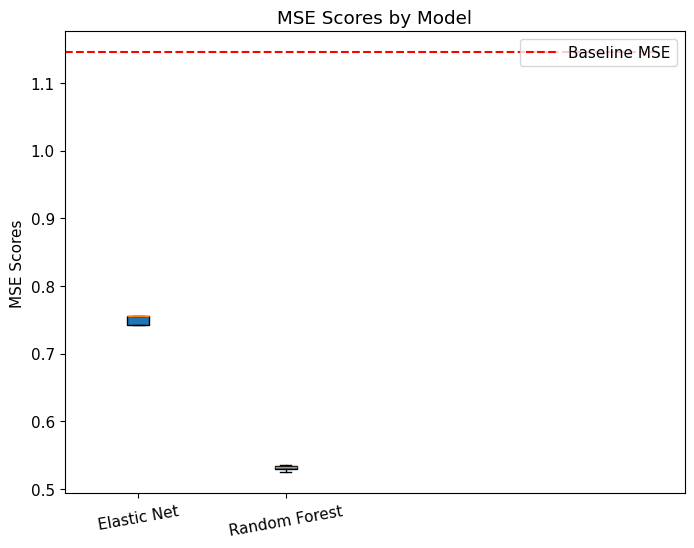

In [201]:
import matplotlib.pyplot as plt
import numpy as np

data = [elasticnet_mses, randomforest_mses]
labels = ['Elastic Net', 'Random Forest']


plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=labels, patch_artist=True)
plt.xticks(rotation=10)

# Highlight baseline MSE
plt.hlines(baseline_mse, 0.5, 4.5, colors='red', linestyles='dashed', label='Baseline MSE')

plt.title('MSE Scores by Model')
plt.ylabel('MSE Scores')
plt.legend()

plt.savefig('../figures/mses_by_model.png', dpi=1000)

plt.show()


## Global Feature Importance

### Permutation feature importance 

In [202]:
from sklearn.model_selection import train_test_split

ftr_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

np.random.seed(42)

y_train_mean = np.mean(y_train)

nr_runs = 10
scores = []

y_test_pred = randomforest_pipe.predict(X_test)
test_mse = mean_squared_error(y_test,y_test_pred)

print('test MSE =',test_mse)
print('test baseline MSE =', baseline_mse)
# loop through the features
comb_cols = ["domesticGrossYear", "worldwideGrossYear", "budgetYear"]
for ftr in ftr_names:
    print('shuffling '+str(ftr))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr] = np.random.permutation(X_test[ftr].values)
        X_test_shuffled[comb_cols] = np.random.permutation(X_test[comb_cols].values)
        y_test_shuffled_pred = randomforest_pipe.predict(X_test_shuffled)
        acc_scores.append(mean_squared_error(y_test,y_test_shuffled_pred))
    print('   shuffled test MSE:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores.append(acc_scores)
scores = np.array(scores)

test MSE = 0.5243323836428313
test baseline MSE = 1.1448062899495333
shuffling title
   shuffled test MSE: 0.67 +/- 0.021
shuffling runtimeMinutes
   shuffled test MSE: 0.846 +/- 0.048
shuffling numVotes
   shuffled test MSE: 1.438 +/- 0.08
shuffling director
   shuffled test MSE: 0.655 +/- 0.013
shuffling writer
   shuffled test MSE: 0.646 +/- 0.03
shuffling productionBudget
   shuffled test MSE: 0.715 +/- 0.025
shuffling domesticGross
   shuffled test MSE: 0.684 +/- 0.027
shuffling worldwideGross
   shuffled test MSE: 0.7 +/- 0.028
shuffling releaseYear
   shuffled test MSE: 0.68 +/- 0.019
shuffling releaseMonth
   shuffled test MSE: 0.683 +/- 0.032
shuffling releaseDay
   shuffled test MSE: 0.65 +/- 0.022
shuffling genre-1
   shuffled test MSE: 0.726 +/- 0.035
shuffling genre-2
   shuffled test MSE: 0.69 +/- 0.028
shuffling genre-3
   shuffled test MSE: 0.655 +/- 0.034
shuffling budgetYear
   shuffled test MSE: 0.644 +/- 0.024
shuffling domesticGrossYear
   shuffled test MSE: 0.663 

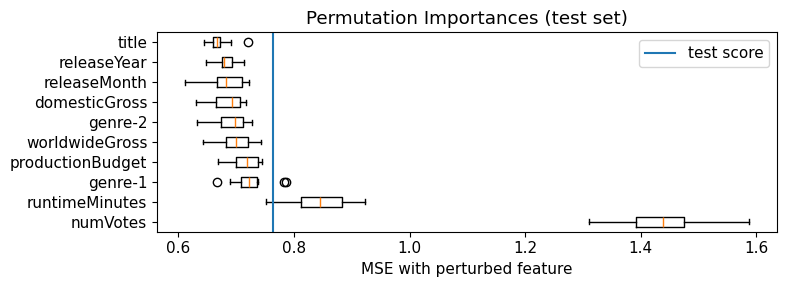

In [203]:
import matplotlib.pylab as plt

sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1][:10]
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(8,3))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('MSE with perturbed feature')
plt.legend()
plt.tight_layout()

plt.savefig('../figures/permutation_importances.png', dpi=600)

plt.show()

### Random forest feature importances

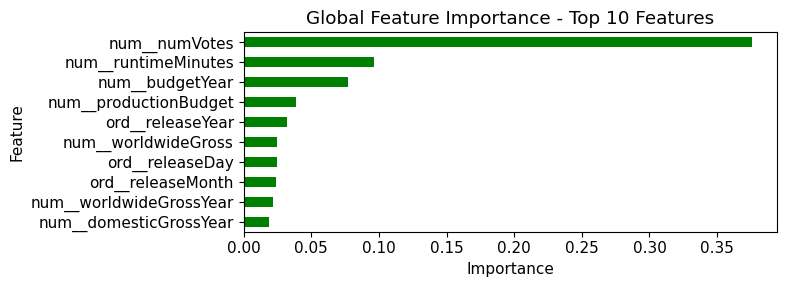

In [204]:
import pandas as pd

prep = randomforest_pipe.named_steps['prep']
prep_cols = prep.get_feature_names_out()

# random forest built-in feature importance
global_importances = pd.Series(randomforest_model.feature_importances_, index=prep_cols)
top_10_importances = global_importances.sort_values(ascending=True).tail(10)

plt.figure(figsize=(8, 3))
top_10_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Top 10 Features")

plt.tight_layout()
plt.savefig('../figures/randforest_feature_importances.png', dpi=600)

plt.show()